#Métaheuristique (Voisinage) pour Coloration du Graphe

#### 1. **Membres de l'équipe :**
  - Aoulmi Lina
  - Hamadene Kamelia
  - Laouzai Lina
  - Amoura Yousra
  - Ouadi Amina Tinhinene
  - Ouikene Youcef

#### 2. **Introduction :**

  La coloration de graphe est un problème fondamental d’optimisation combinatoire qui consiste à attribuer une couleur à chaque sommet d’un graphe de manière à ce que deux sommets adjacents ne partagent jamais la même couleur, tout en minimisant le nombre total de couleurs utilisées.

  Étant donné la complexité NP-difficile du problème, on utilise des heuristiques et des métaheuristiques pour obtenir des solutions approchées. Les heuristiques, comme DSATUR ou Welsh-Powell, appliquent des règles simples pour produire rapidement une solution. Les métaheuristiques, plus puissantes, permettent une exploration plus large de l’espace des solutions.

Dans ce travail, nous allons utilisé deux métaheuristiques :


1.   **Recuit Simulé (RS)**
2.   **Recherche Tabou (RT)**





In [ ]:
# Importation des bibliothéques
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from google.colab import files
import random
import copy
import math
import seaborn as sns

In [ ]:
def lire_fichier_col(filename):
    """
    Lit un fichier au format DIMACS .col et retourne un graphe NetworkX
    """
    G = nx.Graph()

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('e'):  # Ligne décrivant une arête
                _, u, v = line.split()
                G.add_edge(int(u), int(v))
            elif line.startswith('n'):  # Ligne décrivant un nœud (optionnel)
                parts = line.split()
                if len(parts) >= 3:
                    _, node, weight = parts
                    G.add_node(int(node), weight=int(weight))

    # Ajouter des nœuds isolés s'ils ne sont pas présents dans les arêtes
    if G.number_of_nodes() > 0:
        max_node = max(G.nodes())
        for i in range(1, max_node + 1):
            if i not in G:
                G.add_node(i)

    return G


In [ ]:
# Chargement du graphe à partir d'un fichier benchmark
def charger_graphe_benchmark():
    print("Veuillez télécharger un fichier benchmark au format .col")
    uploaded = files.upload()

    if not uploaded:
        print("Aucun fichier n'a été téléchargé. Utilisation d'un graphe aléatoire de test.")
        return nx.gnp_random_graph(10, 0.5)

    filename = next(iter(uploaded))
    G = lire_fichier_col(filename)

    print(f"Graphe chargé avec succès : {G.number_of_nodes()} sommets et {G.number_of_edges()} arêtes")
    return G, filename

In [ ]:
## Visualisation de graphes

def visualiser_graphe_colore(G, coloration):
    """
    Visualise un graphe avec une coloration donnée
    """
    # Assigner des couleurs prédéfinies pour la visualisation
    colors = plt.cm.rainbow(np.linspace(0, 1, max(coloration.values()) + 1))

    # Créer une liste de couleurs pour chaque nœud
    node_colors = [colors[coloration[node]] for node in G.nodes()]

    # Positions des nœuds
    pos = nx.spring_layout(G, seed=42)

    # Dessiner le graphe
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_weight='bold')
    plt.title(f"Coloration avec {max(coloration.values()) + 1} couleurs")
    plt.show()

# Fonctions utilitaires

## Fonctions utilitaires pour le Récuit Simulé (RS)

In [ ]:
##Fonction d’évaluation (Compter le nombre de conflits)
def compute_conflicts(graph, colors_dict):
    conflicts = 0
    for u, v in graph.edges():
        if colors_dict[u] == colors_dict[v]:
            conflicts += 1
    return conflicts


In [ ]:
# Génération de voisinage
def get_neighbor(colors_dict, num_colors):
    new_colors = colors_dict.copy()
    node = random.choice(list(new_colors.keys()))
    new_colors[node] = random.randint(0, num_colors - 1)
    return new_colors


In [ ]:
# Compter le nombre de couleurs distinctes utilisées dans la solution
def count_unique_colors(colors_dict):
    return len(set(colors_dict.values()))

## Fonctions utilitaires pour la Recherche de Tabou (RT)

In [ ]:
def est_coloration_valide(G, coloration):
    """
    Vérifie qu'aucun sommet adjacent ne partage la même couleur.
    """
    for u, v in G.edges():
        if coloration[u] == coloration[v]:
            print(f"Conflit détecté entre les sommets {u} et {v} (couleur {coloration[u]})")
            return False
    return True


In [ ]:
def compter_couleurs(coloration):
    """
    Compte le nombre de couleurs utilisées dans une coloration.
    """
    return max(coloration.values())

In [ ]:
def afficher_resultats(G, coloration_initiale, coloration_finale):
    """
    Affiche les résultats de la recherche tabou.
    """
    nb_couleurs_initial = compter_couleurs(coloration_initiale)
    nb_couleurs_final = compter_couleurs(coloration_finale)

    print("\n===== RÉSULTATS =====")
    print(f"Nombre de couleurs initial: {nb_couleurs_initial}")
    print(f"Nombre de couleurs final: {nb_couleurs_final}")
    print(f"Amélioration: {nb_couleurs_initial - nb_couleurs_final} couleurs ({((nb_couleurs_initial - nb_couleurs_final) / nb_couleurs_initial * 100):.2f}%)")

    if est_coloration_valide(G, coloration_finale):
        print("La coloration finale est correcte.")
    else:
        print("La coloration finale contient des conflits.")

# Recuit Simulé (RS)

Le Recuit Simulé (RS) est une métaheuristique inspirée du processus de refroidissement des métaux.

Il commence avec une solution aléatoire et explore les solutions voisines.
Il accepte :

*   Les solutions meilleures
*   Et parfois des solutions moins bonnes (avec une certaine probabilité décroissante) pour éviter de rester bloqué dans un ***optimum local***.

La probabilité d'accepter une mauvaise solution diminue progressivement selon une température qui baisse au fil des itérations.

## Principe de fonctionnement

1. **Solution initiale**

Cette fonction attribue une couleur à chaque nœud du graphe en utilisant une heuristique gloutonne. Les étapes sont les suivantes :


1. Mélange aléatoire des nœuds : Les nœuds du graphe sont récupérés et mélangés de manière aléatoire, afin de traiter les nœuds dans un ordre non déterminé, contrairement à l'approche traditionnelle où les nœuds sont triés par degré.


2. Attribution des couleurs : Pour chaque nœud, les couleurs des voisins déjà colorés sont collectées. La fonction attribue la plus petite couleur disponible qui n'est pas utilisée par un voisin.



In [ ]:
def coloration_gloutonne(G):
    import random
    colors = {}  # Utilisation d'un dictionnaire pour éviter les problèmes d'indexation

    # Obtenez les nœuds du graphe et mélangez-les de manière aléatoire
    nodes = list(G.nodes())
    random.shuffle(nodes)

    for node in nodes:
        used_colors = set()
        # Collecter les couleurs des voisins
        for neighbor in G.neighbors(node):
            if neighbor in colors:  # Si le voisin a déjà une couleur, on l'ajoute
                used_colors.add(colors[neighbor])

        # Trouver la première couleur disponible
        color = 0
        while color in used_colors:
            color += 1

        colors[node] = color

    return colors

2. **Algorithme Recuit Simulé**

L'algorithme de **recuit simulé** est une méthode d'optimisation probabiliste inspirée du processus physique de refroidissement des matériaux. Il est utilisé ici pour trouver une solution optimale de coloration de graphes. L'algorithme fonctionne comme suit :


1. **Initialisation :** Une solution de départ est générée avec une méthode
   gloutonne.

2. **Itérations :** À chaque étape, une solution voisine est générée. Si elle améliore la solution actuelle, elle est acceptée. Sinon, elle est acceptée avec une probabilité qui diminue avec la température.

3. **Refroidissement :** La température baisse progressivement, réduisant les chances d'accepter une solution moins bonne.

4. **Arrêt :** L'algorithme s'arrête lorsque la température atteint un seuil minimum ou après un nombre d'itérations défini.



In [ ]:
import random
import math

def simulated_annealing(G, T_init, alpha, T_min, max_iter):
    # Initialisation
    current_solution = coloration_gloutonne(G)
    current_conflicts = compute_conflicts(G, current_solution)
    best_solution = current_solution
    best_conflicts = current_conflicts

    T = T_init
    iter_count = 0

    while T > T_min and iter_count < max_iter:
        # Générer un voisin de la solution actuelle
        neighbor_solution = get_neighbor(current_solution, max(current_solution.values()) + 1)
        neighbor_conflicts = compute_conflicts(G, neighbor_solution)

        delta_conflicts = neighbor_conflicts - current_conflicts

        # Critère d'acceptation
        if delta_conflicts < 0 or random.random() < math.exp(-delta_conflicts / T):
            current_solution = neighbor_solution
            current_conflicts = neighbor_conflicts

            if current_conflicts < best_conflicts:
                best_solution = current_solution
                best_conflicts = current_conflicts

        T *= alpha
        iter_count += 1

    return best_solution


# Recherch de Tabou (RT)


La recherche tabou est une **métaheuristique** utilisée pour résoudre des problèmes d’optimisation combinatoire difficiles, comme le problème de la coloration de graphe. Elle s’appuie sur une idée simple : **explorer intelligemment l’espace des solutions**, même si cela implique parfois de **passer par des solutions moins bonnes**, afin **d’éviter de rester bloqué dans un optimum local**.





## Principe de fonctionnement

1. **Solution initiale**

La première étape consiste à générer une solution initiale, c’est-à-dire une coloration valide du graphe, en utilisant une **heuristique gloutonne simple**. Contrairement à des heuristiques plus sophistiquées (comme DSATUR) qui peuvent fournir de très bons résultats dès le départ, nous préférons ici éviter d'atteindre trop rapidement un optimum local, ce qui risquerait de bloquer la recherche dans une région peu prometteuse de l’espace des solutions. Cette heuristique de départ repose sur un principe très simple :



*   Les sommets du graphe sont d’abord triés dans un ordre aléatoire.
*   Ensuite, pour chaque sommet, on attribue la plus petite couleur disponible, c’est-à-dire la première couleur qui n’est pas utilisée par ses voisins déjà colorés.



In [ ]:
def heuristique_gloutonne_aleatoire(G):
    """
    Heuristique gloutonne avec ordre aléatoire : retourne une coloration correcte (sans conflit).

    Paramètres :
    G : networkx.Graph : Le graphe à colorier. Les sommets doivent être identifiables (entiers ou chaînes).

    Retourne :
    coloration : dict : Dictionnaire représentant une solution valide de coloration sans conflit,

    """
    coloration = {}
    noeuds = list(G.nodes())
    for noeud in noeuds:
        couleurs_utilisées = {coloration[voisin] for voisin in G.neighbors(noeud) if voisin in coloration}
        couleur = 1
        while couleur in couleurs_utilisées:
            couleur += 1
        coloration[noeud] = couleur
    nb_couleurs = max(coloration.values())
    print(f"Coloration valide trouvée avec {nb_couleurs} couleurs.")
    return coloration

2. **Recherche dans le voisinage**

Une fois la solution initiale obtenue, l’algorithme entre dans une phase d’exploration de voisinage, élément central de la recherche tabou. Le principe consiste à génèrer les mouvements potentiels que l’on peut appliquer à la solution actuelle dans le but de l’améliorer.

Un mouvement est défini ici comme un couple `(sommet, nouvelle_couleur)`, qui représente un changement de couleur pour un sommet donné, à condition que ce changement ne provoque pas de conflit (deux voisins de même couleur). Pour ce faire :



*   Sélectionner les sommets actuellement colorés avec la couleur maximale. Ces sommets sont les candidats prioritaires à la recoloration, car changer leur couleur permettrait de réduire le nombre total de couleurs utilisées.
*   Pour chqacun de ces sommets si une couleur est disponible (non utilisée par les voisins), créer un mouvement `(sommet, nouvelle couleur)` et l’ajouter à la liste des mouvements.



In [ ]:
def trouver_voisinage(G, coloration, nb_couleurs_cible):
    """
    Génère une liste de mouvements possibles pour améliorer la solution de coloration.

    Paramètres :
    G : networkx.Graph : Le graphe sur lequel la recherche de coloration est effectuée.
    coloration : dict : Dictionnaire représentant la coloration actuelle, sous la forme {sommet: couleur}.
    nb_couleurs_cible : int : Nombre maximum de couleurs qu'on souhaite essayer d'utiliser dans cette étape.

    Retourne :
    mouvements : list of tuples : Une liste de mouvements possibles, où chaque mouvement est un tuple (sommet, nouvelle_couleur).
                  Ces mouvements correspondent à des tentatives de recoloration de sommets avec une couleur inférieure
                            au nombre de couleurs cible, tout en évitant les conflits avec les voisins.
    """
    mouvements = []

    # D'abord, essayer de recolorer les sommets qui utilisent la couleur maximale
    sommets_couleur_max = [s for s, c in coloration.items() if c == nb_couleurs_cible]

    for sommet in sommets_couleur_max:
        # Couleurs utilisées par les voisins
        couleurs_voisins = {coloration[voisin] for voisin in G.neighbors(sommet)}

        # Couleurs disponibles (inférieures à nb_couleurs_cible)
        for couleur in range(1, nb_couleurs_cible):
            if couleur not in couleurs_voisins:
                mouvements.append((sommet, couleur))

    # Si aucun mouvement n'est trouvé, essayer d'autres types de mouvements
    if not mouvements:
        # Essayer de redistribuer les couleurs pour créer plus d'opportunités
        # Choisir aléatoirement quelques sommets et essayer de les recolorer
        noeuds = list(G.nodes())
        random.shuffle(noeuds)
        for sommet in noeuds[:min(50, len(noeuds))]:  # Limiter à 50 sommets pour l'efficacité
            couleur_actuelle = coloration[sommet]
            couleurs_voisins = {coloration[voisin] for voisin in G.neighbors(sommet)}

            # Essayer toutes les couleurs disponibles
            for couleur in range(1, nb_couleurs_cible + 1):
                if couleur != couleur_actuelle and couleur not in couleurs_voisins:
                    mouvements.append((sommet, couleur))

    return mouvements

**3. Evaluation du mouvemlet**

Chaque mouvement généré doit être évalué avant d’être appliqué, afin de mesurer son impact sur la qualité de la solution. Cette étape permet de guider la recherche vers les meilleures solutions possibles, même si elles sont temporairement moins bonnes.

L’évaluation d’un mouvement repose ici sur le `nombre de conflits` qu’il engendre, c’est-à-dire le nombre de voisins du sommet concerné qui auraient la même couleur après le changement. Pour ce faire :


*   Identifier le sommet et la nouvelle couleur proposés par le mouvement.
*   Appliquer temporairement ce changement à la solution actuelle.
*   Parcourir les voisins du sommet et compter combien d’entre eux ont désormais la même couleur .

*  Restaurer la couleur d’origine du sommet pour ne pas modifier la solution actuelle.

*  Retourner le nombre total de conflits générés, qui servira à comparer les différents mouvements entre eux.




In [ ]:
def evaluer_mouvement(G, coloration, mouvement):
    """
    Évalue un mouvement potentiel dans la coloration d’un graphe.

    Paramètres :
    G : networkx.Graph : Le graphe dont les sommets sont à colorier.
    coloration : dict : Dictionnaire représentant la coloration actuelle, sous la forme {sommet: couleur}.
    mouvement : tuple : Un mouvement proposé, représenté par un tuple (sommet, nouvelle_couleur).

    Retourne :
    conflits : int : Le nombre de conflits générés si le mouvement est appliqué, c’est-à-dire le nombre de voisins du sommet ayant la même couleur.
    """
    sommet, nouvelle_couleur = mouvement
    ancienne_couleur = coloration[sommet]

    # Appliquer temporairement le mouvement
    coloration[sommet] = nouvelle_couleur

    # Compter les conflits
    conflits = 0
    for voisin in G.neighbors(sommet):
        if coloration[voisin] == nouvelle_couleur:
            conflits += 1

    # Restaurer la coloration originale
    coloration[sommet] = ancienne_couleur

    return conflits





**4. Recherche tabou**

Cette phase constitue le cœur de l’algorithme : on y applique de manière itérative la stratégie de recherche tabou afin d’améliorer progressivement la solution en explorant l’espace des solutions voisines, tout en évitant de revenir sur des solutions déjà explorées. Les étapes globales sont les suivantes :


*   Initialiser la solution courante avec la coloration initiale (générée par l'heuristique gloutonne).
*   Initialiser une liste tabou, qui empêchera temporairement certains mouvements (changement de couleur pour un sommet déjà essayé).
*   À chaque itération :
  *   Générer des mouvements potentiels à partir de la solution courante à l’aide du voisinage.
  *   Si aucun mouvement n’est possible, essayer avec une couleur inférieure pour forcer la progression.
  *   Évaluer chaque mouvement (sauf ceux dans la liste tabou) selon le nombre de conflits qu’il génère.
  *   Sélectionner le meilleur mouvement non tabou ; si tous les mouvements sont tabous, appliquer la règle d’aspiration (accepter le moins mauvais mouvement malgré l’interdiction).
  *   Appliquer ce mouvement et l’ajouter à la liste tabou (empêcher sa réapplicaion temporairement pour eviter les cycles).
  *   Mettre à jour le nombre de couleurs utilisées.
  *   Si la nouvelle solution est valide et meilleure (moins de couleurs utilisées), la mémoriser comme meilleure solution et soulution courante.
*   Répéter ce processus pendant un nombre d’itérations fixé ou jusqu’à stagnation.


In [ ]:
def recherche_tabou(G, coloration_initiale, max_iterations=100, taille_liste_tabou=10):
    """
    Applique une recherche tabou pour améliorer une solution de coloration de graphe.

    Paramètres :
    G : networkx.Graph : Le graphe à colorier.
    coloration_initiale : dict : Dictionnaire représentant une coloration initiale, de la forme {sommet: couleur}.
    max_iterations : int, optionnel : Nombre maximal d'itérations de la recherche tabou (par défaut 100).
    taille_liste_tabou : int, optionnel : Taille maximale de la liste tabou (par défaut 10).

    Retourne :
    meilleure_coloration : dict : La meilleure coloration trouvée (minimisant le nombre de couleurs et respectant les contraintes).
    historique_nb_couleurs : list : Liste du nombre de couleurs utilisé à chaque itération, pour visualiser l'évolution de l'algorithme.
    """
    # Copie de la coloration initiale
    coloration_courante = coloration_initiale.copy()
    meilleure_coloration = coloration_courante.copy()

    # Initialiser la liste tabou (stocke les paires (sommet, couleur))
    liste_tabou = []

    # Nombre de couleurs initial
    nb_couleurs_initial = compter_couleurs(coloration_initiale)
    nb_couleurs_courant = nb_couleurs_initial
    nb_couleurs_meilleur = nb_couleurs_initial

    # Suivre l'évolution
    historique_nb_couleurs = [nb_couleurs_initial]

    # Boucle principale
    for iteration in range(max_iterations):
        # Notre objectif est de réduire le nombre de couleurs
        nb_couleurs_cible = nb_couleurs_courant

        # Trouver des mouvements potentiels (essayer de colorier les sommets avec une couleur inférieure)
        mouvements = trouver_voisinage(G, coloration_courante, nb_couleurs_cible)

        # Si aucun mouvement n'est possible, on essaie la couleur inférieure
        if not mouvements and nb_couleurs_cible > 1:
            nb_couleurs_cible -= 1
            mouvements = trouver_voisinage(G, coloration_courante, nb_couleurs_cible)

        if not mouvements:
            break

        # Évaluer les mouvements
        meilleur_mouvement = None
        meilleur_score = float('inf')

        for mouvement in mouvements:
            # Vérifier si le mouvement est tabou
            if mouvement in liste_tabou:
                continue

            # Évaluer le mouvement
            score = evaluer_mouvement(G, coloration_courante, mouvement)

            # Mettre à jour le meilleur mouvement
            if score < meilleur_score:
                meilleur_score = score
                meilleur_mouvement = mouvement

        # Si aucun mouvement non-tabou n'est trouvé
        if meilleur_mouvement is None:
            # Aspiration: on prend le moins tabou
            meilleur_mouvement = mouvements[0]
            meilleur_score = evaluer_mouvement(G, coloration_courante, meilleur_mouvement)

            for mouvement in mouvements:
                score = evaluer_mouvement(G, coloration_courante, mouvement)
                if score < meilleur_score:
                    meilleur_score = score
                    meilleur_mouvement = mouvement

        # Appliquer le meilleur mouvement
        sommet, nouvelle_couleur = meilleur_mouvement
        ancienne_couleur = coloration_courante[sommet]
        coloration_courante[sommet] = nouvelle_couleur

        # Ajouter le mouvement à la liste tabou
        liste_tabou.append((sommet, ancienne_couleur))
        if len(liste_tabou) > taille_liste_tabou:
            liste_tabou.pop(0)

        # Mettre à jour le nombre de couleurs
        nb_couleurs_courant = compter_couleurs(coloration_courante)
        historique_nb_couleurs.append(nb_couleurs_courant)

        # Vérifier si la solution est meilleure
        if est_coloration_valide(G, coloration_courante):
            if nb_couleurs_courant < nb_couleurs_meilleur:
                meilleure_coloration = coloration_courante.copy()
                nb_couleurs_meilleur = nb_couleurs_courant


    return meilleure_coloration, historique_nb_couleurs

5. **Trouver les bons parametres**

La fonction `trouver_parametres_optimaux` a pour objectif d’identifier automatiquement les meilleurs paramètres pour l’algorithme de recherche tabou appliqué à la coloration de graphes. En fonction de la taille du graphe, elle adapte dynamiquement les plages de valeurs pour le nombre maximal d’itérations et la taille de la liste tabou, puis teste chaque combinaison. Pour chaque configuration, elle applique la recherche tabou à partir d’une solution initiale, mesure le nombre de couleurs utilisées et le temps d’exécution, et conserve la meilleure solution trouvée. Cette approche permet d’optimiser la performance de l’algorithme sans avoir à choisir les paramètres manuellement.

In [ ]:
def trouver_parametres_optimaux(G, coloration_initiale):
    """
    Teste différentes combinaisons de paramètres pour la recherche tabou,
    adaptées à la taille du graphe, et retourne les meilleurs paramètres
    ainsi que la meilleure coloration trouvée.

    Paramètres:
    G : networkx.Graph : Le graphe à colorier
    coloration_initiale : dict : Coloration initiale

    Retourne:
    tuple : (max_iterations, taille_liste_tabou, meilleure_coloration, temps_execution)
    """
    # Nombre de sommets dans le graphe
    n = G.number_of_nodes()

    # Adapter les valeurs en fonction de la taille du graphe
    if n < 50:  # Petits graphes
        max_iterations_values = [100, 200, 400]
        taille_liste_tabou_values = [5, 10, 15]
    elif n < 200:  # Graphes moyens
        max_iterations_values = [800, 1000, 2000, 3000]
        taille_liste_tabou_values = [10, 20, 30]
    elif n < 500:  # Grands graphes
        max_iterations_values = [1000, 2000, 3000, 4000, 5000]
        taille_liste_tabou_values = [20, 30, 40]
    else:  # Très grands graphes
        max_iterations_values = [4000, 5000, 6000, 7000]
        taille_liste_tabou_values = [40, 60, 80]


    meilleure_coloration = None
    meilleur_nb_couleurs = float('inf')
    meilleur_temps = 0
    meilleurs_parametres = (0, 0)
    nb_couleurs_initial = compter_couleurs(coloration_initiale)

    print("\nTest des combinaisons de paramètres:")
    print("max_iterations, taille_liste_tabou, nb_couleurs, temps, amélioration")

    for max_iter in max_iterations_values:
        for taille_tabou in taille_liste_tabou_values:
            # Copier la coloration initiale pour éviter les modifications
            coloration_test = coloration_initiale.copy()

            # Exécuter la recherche tabou avec ces paramètres
            debut = time.time()
            coloration_finale, _ = recherche_tabou(G, coloration_test,
                                                  max_iterations=max_iter,
                                                  taille_liste_tabou=taille_tabou)
            fin = time.time()
            temps_execution = fin - debut

            # Évaluer la qualité du résultat
            nb_couleurs_final = compter_couleurs(coloration_finale)
            amelioration = nb_couleurs_initial - nb_couleurs_final

            print(f"{max_iter}, {taille_tabou}, {nb_couleurs_final}, {temps_execution:.2f}s, {amelioration}")

            # Mettre à jour les meilleurs paramètres si on a trouvé une meilleure coloration
            if nb_couleurs_final < meilleur_nb_couleurs:
                meilleur_nb_couleurs = nb_couleurs_final
                meilleurs_parametres = (max_iter, taille_tabou)
                meilleure_coloration = coloration_finale.copy()
                meilleur_temps = temps_execution

    print(f"\n======Meilleurs paramètres trouvés:========")
    print(f"max_iterations = {meilleurs_parametres[0]}")
    print(f"taille_liste_tabou = {meilleurs_parametres[1]}")
    print(f"Meilleur nombre de couleurs: {meilleur_nb_couleurs}")
    print(f"Temps d'exécution: {meilleur_temps:.2f} secondes")
    print(f"Amélioration: {nb_couleurs_initial - meilleur_nb_couleurs} couleurs")


    return meilleurs_parametres[0], meilleurs_parametres[1], meilleure_coloration, meilleur_temps

# Tests et comparaison des résultats


## Test de la methode Recuit Simulé (RS)

Veuillez télécharger un fichier benchmark au format .col


Saving r.250.5.col to r.250.5 (12).col
Graphe chargé avec succès : 250 sommets et 14849 arêtes
Coloration initiale (sans conflit) pour le graphe r.250.5 (12).col : {22: 0, 157: 1, 1: 2, 27: 0, 174: 1, 44: 3, 105: 4, 241: 2, 29: 5, 57: 6, 203: 3, 118: 5, 210: 0, 100: 4, 113: 7, 148: 6, 172: 7, 111: 0, 205: 1, 155: 3, 153: 2, 190: 8, 177: 6, 135: 8, 126: 9, 129: 9, 55: 10, 95: 10, 45: 11, 235: 8, 230: 9, 146: 12, 178: 12, 76: 13, 127: 11, 223: 14, 242: 5, 144: 4, 123: 14, 26: 15, 149: 15, 211: 16, 115: 4, 196: 17, 128: 18, 195: 16, 3: 10, 198: 19, 240: 7, 184: 12, 109: 14, 59: 6, 66: 16, 37: 13, 89: 20, 67: 2, 208: 15, 165: 9, 207: 21, 163: 20, 238: 17, 98: 22, 169: 23, 31: 7, 170: 1, 192: 18, 147: 10, 181: 11, 218: 6, 179: 17, 80: 24, 224: 22, 156: 25, 11: 4, 63: 19, 202: 21, 201: 0, 245: 24, 116: 13, 136: 23, 36: 19, 52: 13, 84: 26, 73: 27, 214: 28, 171: 26, 41: 27, 30: 29, 162: 25, 33: 30, 54: 23, 145: 20, 187: 28, 185: 31, 232: 30, 60: 31, 34: 26, 191: 32, 38: 8, 206: 21, 20: 15, 107

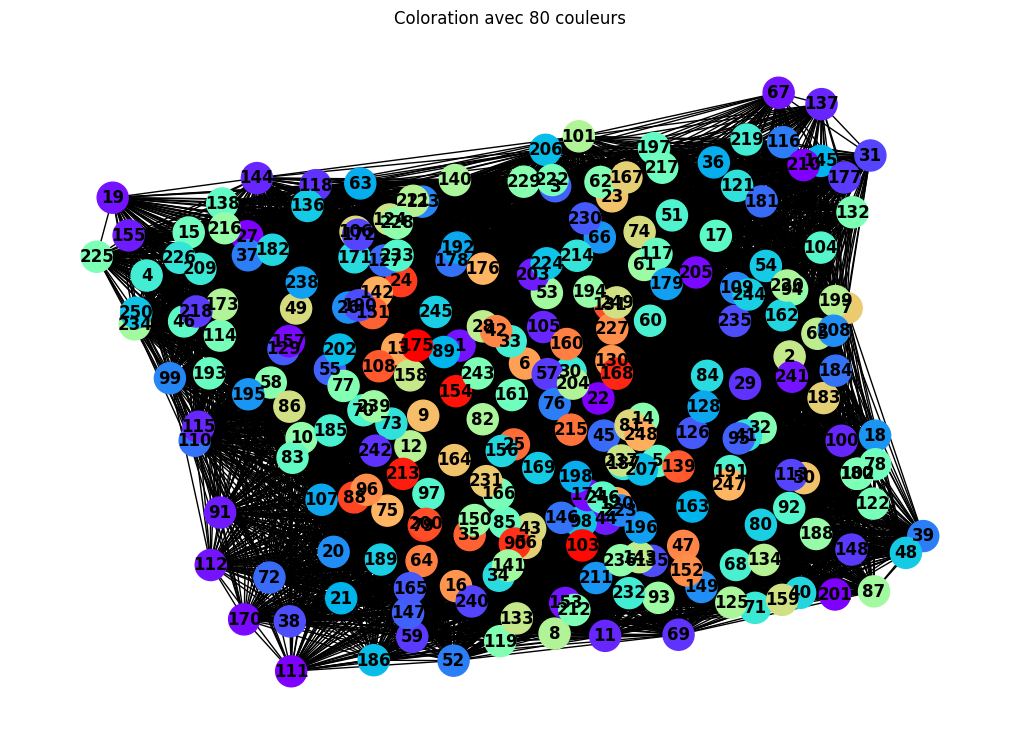


Test avec T_init = 1000, alpha = 0.9, max_iter = 500
Nombre de conflits: 0
Nombre de couleurs utilisées dans la solution: 79
Temps d'exécution du recuit simulé: 0.35 secondes

Test avec T_init = 1000, alpha = 0.9, max_iter = 10000
Nombre de conflits: 0
Nombre de couleurs utilisées dans la solution: 79
Temps d'exécution du recuit simulé: 0.29 secondes

Test avec T_init = 1000, alpha = 0.9, max_iter = 20000
Nombre de conflits: 0
Nombre de couleurs utilisées dans la solution: 80
Temps d'exécution du recuit simulé: 0.31 secondes

Test avec T_init = 1000, alpha = 0.98, max_iter = 500
Nombre de conflits: 0
Nombre de couleurs utilisées dans la solution: 79
Temps d'exécution du recuit simulé: 1.47 secondes

Test avec T_init = 1000, alpha = 0.98, max_iter = 10000
Nombre de conflits: 0
Nombre de couleurs utilisées dans la solution: 81
Temps d'exécution du recuit simulé: 1.50 secondes

Test avec T_init = 1000, alpha = 0.98, max_iter = 20000
Nombre de conflits: 0
Nombre de couleurs utilisées dans

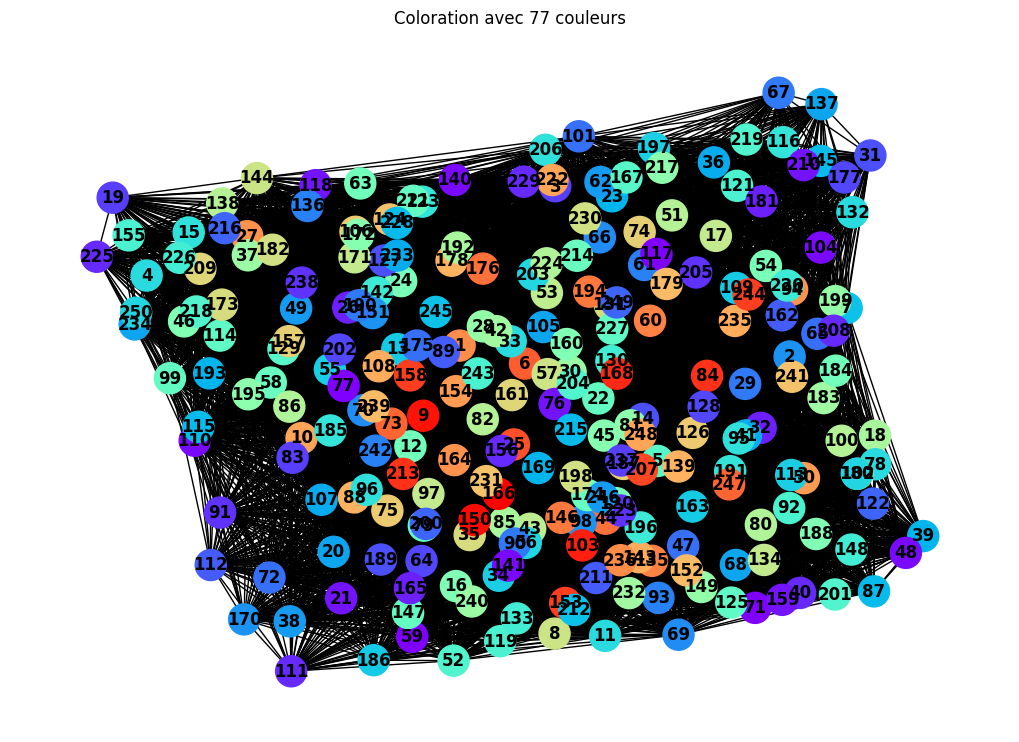

In [ ]:
import time

# Compter le nombre de couleurs distinctes utilisées dans la solution
def count_unique_colors(colors_dict):
    return len(set(colors_dict.values()))

def main():
    # Charger le graphe depuis un fichier
    G, filename = charger_graphe_benchmark()  # Récupération du graphe et du nom du fichier

    # 1. Exécution de l'algorithme glouton sans conflits
    initial_colors = coloration_gloutonne(G)
    print(f"Coloration initiale (sans conflit) pour le graphe {filename} :", initial_colors)
    initial_conflicts = compute_conflicts(G, initial_colors)
    print(f"Nombre de conflits initial pour {filename}:", initial_conflicts)
    visualiser_graphe_colore(G, initial_colors)

    # 2. Tests avec différentes valeurs de T_init, alpha et max_iter
    T_init_values = [1000, 5000, 10000]  # Température initiale
    alpha_values = [0.9, 0.98, 0.99]  # Facteur de refroidissement
    max_iter_values = [500, 10000, 20000]  # Nombre d'itérations maximum
    best_solution = None
    best_conflicts = float('inf')  # Initialisez avec une valeur très haute
    best_num_colors = float('inf')  # Initialisez avec une valeur très haute

    for T_init in T_init_values:
        for alpha in alpha_values:
            for max_iter in max_iter_values:
                print(f"\nTest avec T_init = {T_init}, alpha = {alpha}, max_iter = {max_iter}")

                # Temps de début pour le recuit simulé
                start_time = time.time()

                # Appel de l'algorithme de recuit simulé
                result = simulated_annealing(G, T_init=T_init, alpha=alpha, T_min=0.1, max_iter=max_iter)

                # Temps de fin pour le recuit simulé
                end_time = time.time()

                # Calcul des conflits et du nombre de couleurs utilisés
                conflicts = compute_conflicts(G, result)
                num_colors = count_unique_colors(result)

                # Affichage des résultats
                print(f"Nombre de conflits: {conflicts}")
                print(f"Nombre de couleurs utilisées dans la solution: {num_colors}")
                print(f"Temps d'exécution du recuit simulé: {end_time - start_time:.2f} secondes")

                # Mise à jour de la meilleure solution trouvée en fonction du nombre de couleurs
                if num_colors < best_num_colors:
                    best_num_colors = num_colors
                    best_conflicts = conflicts  # Mettre à jour les conflits associés à cette solution
                    best_solution = result

    # Afficher le meilleur résultat basé sur le nombre de couleurs
    print("\nMeilleure solution trouvée :")
    print(best_solution)
    print("Nombre de conflits dans la meilleure solution:", best_conflicts)
    print("Nombre de couleurs utilisées dans la meilleure solution:", best_num_colors)
    visualiser_graphe_colore(G, best_solution)

if __name__ == "__main__":
    main()

## Test de la methode Recherche Tabou (RT)

In [ ]:
def main():
    # Fixer la seed pour la reproductibilité
    random.seed(42)

    # Charger le graphe
    G, filename = charger_graphe_benchmark()
    print(f"Graphe chargé: {filename}")
    print(f"Nombre de nœuds: {G.number_of_nodes()}")
    print(f"Nombre d'arêtes: {G.number_of_edges()}")

    # Obtenir la coloration initiale par heuristique gloutonne
    coloration_initiale = heuristique_gloutonne_aleatoire(G)

    # Vérifier la validité de la coloration initiale
    if est_coloration_valide(G, coloration_initiale):
        print("La coloration initiale est correcte.")
    else:
        print("La coloration initiale contient des conflits.")

    nb_couleurs_initial = len(set(coloration_initiale.values()))
    print(f"Nombre de couleurs initial : {nb_couleurs_initial}")

    # Trouver les meilleurs paramètres et récupérer la meilleure coloration
    print("\n===== RECHERCHE DES MEILLEURS PARAMÈTRES =====")
    max_iterations, taille_liste_tabou, meilleure_coloration, temps_execution = trouver_parametres_optimaux(G, coloration_initiale)

    # Affichage du rapport final
    nb_couleurs_final = len(set(meilleure_coloration.values()))
    amelioration = nb_couleurs_initial - nb_couleurs_final

    print(f"\n===== RÉSULTAT FINAL =====")
    print(f"Paramètres retenus: max_iterations={max_iterations}, taille_liste_tabou={taille_liste_tabou}")
    print(f"Nombre de couleurs initial: {nb_couleurs_initial}")
    print(f"Nombre de couleurs final: {nb_couleurs_final}")
    print(f"Réduction du nombre de couleurs: {amelioration} couleurs")
    print(f"Temps d'exécution pour cette configuration: {temps_execution:.2f} secondes")
    if amelioration > 0:
        print(f"Amélioration effective de {amelioration / nb_couleurs_initial * 100:.2f}%")
        print(f"Rapport qualité/temps: {(amelioration / temps_execution):.2f}")
    else:
        print("Aucune amélioration.")


if __name__ == "__main__":
    main()

Veuillez télécharger un fichier benchmark au format .col


Saving r.250.5.col to r.250.5 (13).col
Graphe chargé avec succès : 250 sommets et 14849 arêtes
Graphe chargé: r.250.5 (13).col
Nombre de nœuds: 250
Nombre d'arêtes: 14849
Coloration valide trouvée avec 79 couleurs.
La coloration initiale est correcte.
Nombre de couleurs initial : 79

===== RECHERCHE DES MEILLEURS PARAMÈTRES =====

Test des combinaisons de paramètres:
max_iterations, taille_liste_tabou, nb_couleurs, temps, amélioration
1000, 20, 76, 5.48s, 3
1000, 30, 77, 4.74s, 2
1000, 40, 75, 5.92s, 4
2000, 20, 73, 9.73s, 6
2000, 30, 74, 9.81s, 5
2000, 40, 76, 10.67s, 3
3000, 20, 74, 14.89s, 5
3000, 30, 74, 15.14s, 5
3000, 40, 74, 15.80s, 5
4000, 20, 72, 18.91s, 7
4000, 30, 74, 21.10s, 5
4000, 40, 74, 19.36s, 5
5000, 20, 74, 24.84s, 5
5000, 30, 74, 25.15s, 5
5000, 40, 71, 24.50s, 8

======Meilleurs paramètres trouvés:========
max_iterations = 5000
taille_liste_tabou = 40
Meilleur nombre de couleurs: 71
Temps d'exécution: 24.50 secondes
Amélioration: 8 couleurs

===== RÉSULTAT FINAL ==

# Comparaison avec l'heuristique DSATUR


## Heuristique DSATUR

In [ ]:
def dsatur(G):
    """
    Implémentation de l'algorithme DSATUR pour la coloration de graphe

    Paramètres:
    G: un graphe NetworkX

    Retourne:
    coloration: dictionnaire avec les sommets comme clés et les couleurs comme valeurs
    temps_execution: temps d'exécution en secondes
    """
    debut = time.time()

    # Initialiser la coloration
    coloration = {}

    # Initialiser le degré de saturation (nombre de couleurs différentes dans le voisinage)
    saturation = {sommet: 0 for sommet in G.nodes()}

    # Tant qu'il reste des sommets à colorer
    while len(coloration) < len(G.nodes()):
        # Sélectionner le sommet non coloré avec la plus grande saturation
        sommets_non_colores = [s for s in G.nodes() if s not in coloration]

        # Trouver le sommet avec la plus grande saturation
        max_saturation = -1
        meilleur_sommet = None

        for sommet in sommets_non_colores:
            if saturation[sommet] > max_saturation:
                max_saturation = saturation[sommet]
                meilleur_sommet = sommet
            elif saturation[sommet] == max_saturation:
                # En cas d'égalité, choisir le sommet avec le plus grand degré
                if G.degree(sommet) > G.degree(meilleur_sommet):
                    meilleur_sommet = sommet

        # Trouver la plus petite couleur disponible pour ce sommet
        couleurs_voisins = {coloration[voisin] for voisin in G.neighbors(meilleur_sommet) if voisin in coloration}
        couleur = 0
        while couleur in couleurs_voisins:
            couleur += 1

        # Attribuer cette couleur au sommet
        coloration[meilleur_sommet] = couleur

        # Mettre à jour la saturation des voisins non colorés
        for voisin in G.neighbors(meilleur_sommet):
            if voisin not in coloration:
                # Compter les couleurs distinctes dans le voisinage
                couleurs_voisins_du_voisin = {coloration[v] for v in G.neighbors(voisin) if v in coloration}
                saturation[voisin] = len(couleurs_voisins_du_voisin)

    fin = time.time()
    temps_execution = fin - debut

    return coloration, temps_execution

## Test de comparaison entre DSATUR et RT

In [ ]:
def comparer_dsatur_et_tabou_sur_graphe(G):
    """
    Compare DSATUR et la recherche tabou sur un graphe donné.

    Paramètres :
    - G : networkx.Graph : le graphe à tester.
    - nom : str : nom du graphe (affichage uniquement).
    """
    print("\n===== COMPARAISON ENTRE DSATUR ET RECHERCHE TABOU =====")

    # Exécuter DSATUR
    coloration_dsatur, temps_dsatur = dsatur(G)
    nb_couleurs_dsatur = compter_couleurs(coloration_dsatur)

    # Exécuter la recherche tabou
    # coloration_initiale = heuristique_gloutonne_aleatoire(G)
    max_iterations, taille_liste_tabou, coloration_tabou, temps_tabou = trouver_parametres_optimaux(G, coloration_dsatur)
    nb_couleurs_tabou = compter_couleurs(coloration_tabou)
    amelioration = nb_couleurs_dsatur - nb_couleurs_tabou

    # Afficher les résultats
    print(f"  - DSATUR : {nb_couleurs_dsatur} couleurs en {temps_dsatur:.4f}s")
    print(f"  - Tabou  : {nb_couleurs_tabou} couleurs en {temps_tabou:.4f}s")
    if amelioration > 0:
        print(f"  - Amélioration : {amelioration} couleurs ({amelioration / nb_couleurs_dsatur * 100:.2f}%)")
    else:
        print("  - Aucune amélioration")

def main():
    """Fonction principale : charge un graphe et le passe à la comparaison"""
    print("Démarrage de la comparaison DSATUR vs Tabou")

    # Charger le graphe ici
    G, fileName = charger_graphe_benchmark()

    # Comparer sur le graphe
    comparer_dsatur_et_tabou_sur_graphe(G)

    print("Comparaison terminée")

if __name__ == "__main__":
    main()

Démarrage de la comparaison DSATUR vs Tabou
Veuillez télécharger un fichier benchmark au format .col


Saving r.250.5.col to r.250.5 (14).col
Graphe chargé avec succès : 250 sommets et 14849 arêtes

===== COMPARAISON ENTRE DSATUR ET RECHERCHE TABOU =====

Test des combinaisons de paramètres:
max_iterations, taille_liste_tabou, nb_couleurs, temps, amélioration
1000, 20, 67, 4.06s, 0
1000, 30, 66, 5.29s, 1
1000, 40, 67, 4.05s, 0
2000, 20, 66, 9.14s, 1
2000, 30, 66, 7.89s, 1
2000, 40, 66, 9.18s, 1
3000, 20, 66, 12.94s, 1
3000, 30, 67, 13.29s, 0
3000, 40, 66, 12.87s, 1
4000, 20, 67, 18.68s, 0
4000, 30, 67, 17.53s, 0
4000, 40, 67, 17.58s, 0
5000, 20, 67, 23.07s, 0
5000, 30, 67, 22.86s, 0
5000, 40, 67, 22.82s, 0

======Meilleurs paramètres trouvés:========
max_iterations = 1000
taille_liste_tabou = 30
Meilleur nombre de couleurs: 66
Temps d'exécution: 5.29 secondes
Amélioration: 1 couleurs
  - DSATUR : 67 couleurs en 0.1227s
  - Tabou  : 66 couleurs en 5.2910s
  - Amélioration : 1 couleurs (1.49%)
Comparaison terminée
